<a href="https://colab.research.google.com/github/mariagontijo/emap-rir-/blob/master/2019sri_mariagontijo_parte1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EMAP - Projeto Final Sistema de Recuperação de Informação -
#### Maria Gabriela G Gontijo

Para o Projeto Final foram selecionados dois tipos de documentos: 


i) relatórios feitos por dirigentes do Banco Central no período de 2001 a 2019;

ii)contratos entre concessiónaria e poder concedente do setor de energia no Brasil, os quais foram assinados no período de 1997 a 2019;  

#### Imports... 

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import clear_output
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from textblob import TextBlob
import io
import math
import string
import nltk 
from wordcloud import WordCloud
import os
import PyPDF2
from math import log
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
import matplotlib.pyplot as plt
import pt_core_news_sm


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import whoosh
import nltk
import string
import shutil
import gensim
import logging
#------------------------------------------------------------------------------------
from IPython.display import display, Markdown, Latex
from collections import defaultdict,Counter,OrderedDict
from math import log
from sklearn.feature_extraction.text import TfidfVectorizer
from numpy.linalg import norm
from string import punctuation
#____________________________________________________________________________________
from gensim import corpora, models, similarities
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel,wrappers,FastText
#____________________________________________________________________________________
from nltk.corpus import machado, mac_morpho,stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.stem.snowball import SnowballStemmer
#____________________________________________________________________________________
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
#____________________________________________________________________________________
from whoosh import sorting
from whoosh.index import create_in, open_dir
from whoosh.fields import *
from whoosh import qparser
from whoosh.qparser import QueryParser

#### Função para leitura dos documentos tipo pdf 

In [0]:
#Leitura dos documentos com a biblioteca pdfminer

def read_pdf(path):
    rsrcmgr = PDFResourceManager()
    retstr = io.StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos=set()
    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password, caching=caching, check_extractable=True): 
        interpreter.process_page(page)
    text = retstr.getvalue()
    text = " ".join(text.replace(u"\xa0", " ").strip().split())  
    fp.close()
    device.close()
    retstr.close()
    return text

Construindo a lista de documentos 

In [0]:
#Corpus em português:
nltk.download('stopwords')
swu = stopwords.words('portuguese')+ list(string.punctuation)
stopwords.words('portuguese')
stemmer = SnowballStemmer('portuguese')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maria.gontijo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
corpus = pd.read_csv("documentos2.csv")
corpus.head()

,Unnamed: 0,id,content
0,0,001-2002.pdf,CONTRATO DE CONCESSÃO DE TRANSMISSÃO Nº 001/20...
1,1,001-2005.pdf,LOTE A PROCESSO No 48500.001318/04-73 CONTRATO...
2,2,001-2011.pdf,CONTRATO DE CONCESSÃO N° 001/2011-ANEEL TRANSM...
3,3,001-2014.pdf,CONTRATO DE C0NcEssA0 N 2 01/2014-ANEEL MATA D...
4,4,001-2017.pdf,€*ANEELAcíucia Naciohal de Enercia EitmcnPROCE...


In [0]:
# Load the regular expression library
import re
# Remove punctuation
corpus['corpus_processed'] = corpus['content'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
corpus['corpus_processed'] = corpus['corpus_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
corpus['corpus_processed'].head()

<>:4: DeprecationWarning: invalid escape sequence \.
<>:4: DeprecationWarning: invalid escape sequence \.
<>:4: DeprecationWarning: invalid escape sequence \.
<ipython-input-6-ad2897a4ea6f>:4: DeprecationWarning: invalid escape sequence \.
  corpus['corpus_processed'] = corpus['content'].map(lambda x: re.sub('[,\.!?]', '', x))


0    contrato de concessão de transmissão nº 001/20...
1    lote a processo no 48500001318/04-73 contrato ...
2    contrato de concessão n° 001/2011-aneel transm...
3    contrato de c0ncessa0 n 2 01/2014-aneel mata d...
4    €*aneelacíucia naciohal de enercia eitmcnproce...
Name: corpus_processed, dtype: object

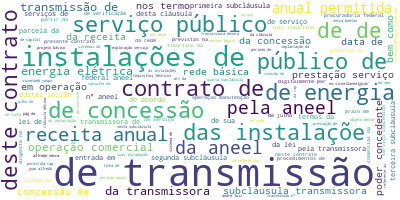

In [0]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(corpus['corpus_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

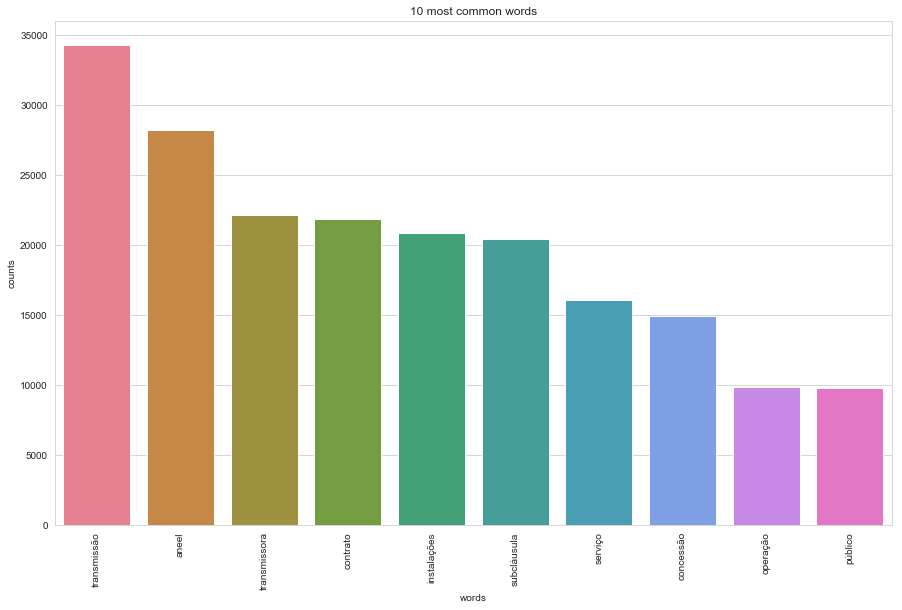

In [0]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the portuguese stop words
count_vectorizer = CountVectorizer(stop_words=swu)
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(corpus['corpus_processed'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

## Indexação e consulta por frase

In [0]:
def whooshSearcher(sentence, corpus):
    #______________________________________________________________________________________________________   
   
    schema = Schema(cont=TEXT(phrase=True, stored=True))
    
    #Criando o indexidr:
    if os.path.exists('indexdir'):
        shutil.rmtree(r'\Users\maria.gontijo\Downloads\indexdir')
        os.mkdir('indexdir')
        ix = create_in("indexdir", schema)
        writer = ix.writer()
        for txt in corpus:
            writer.add_document(cont=txt)
        writer.commit()
    else:
        os.mkdir('indexdir')
        ix = create_in("indexdir", schema)
        writer = ix.writer()
        for txt in corpus:
            writer.add_document(cont=txt)
        writer.commit()
    #______________________________________________________________________________________________________
    
    aux=[]
    positions=[]


    query = QueryParser("cont", schema=ix.schema,group=qparser.OrGroup).parse(sentence)
    facets = sorting.Facets()
    facets.add_field("cont")
    facets.add_field("cont", allow_overlap=True)
    answer = ix.searcher().search(query,limit=10, groupedby=facets)
    for k in answer:
        positions.append(corpus[corpus.isin([k.values()[0]])].index[0])
    for hit in answer:
        aux.append(re.split("\.\.\.", hit.highlights("cont")))
    print("Resultados em ordem de similaridade:")
    print(" ")
    for j in range(min(10,len(aux))):
        print("Trechos do resultado "+str(j+1)+", linha "+str(positions[j])+" do Corpus")
        for i in range(len(aux[j])):
            display(Markdown("Trecho "+str(i)+":  [...] "+aux[j][i]+" [...]"))
        print(" ")


    return positions[:min(10,len(aux))]

<>:36: DeprecationWarning: invalid escape sequence \.
<>:36: DeprecationWarning: invalid escape sequence \.
<>:36: DeprecationWarning: invalid escape sequence \.
<ipython-input-10-19b46a4ce849>:36: DeprecationWarning: invalid escape sequence \.
  aux.append(re.split("\.\.\.", hit.highlights("cont")))


In [0]:
whooshSearcher('riscos do negócio', corpus.content)

Resultados em ordem de similaridade:
 
Trechos do resultado 1, linha 229 do Corpus


Trecho 0:  [...] <b class="match term0">do</b> balanço de <b class="match term1">riscos</b> prescreve ajuste [...]

Trecho 1:  [...] atividade econômica, <b class="match term0">do</b> balanço de <b class="match term1">riscos</b> e das projeções e [...]

Trecho 2:  [...] prospectiva abaixo <b class="match term0">do</b> esperado. • <b class="match term2">Riscos</b> de elevação da inflação [...]

 
Trechos do resultado 2, linha 265 do Corpus


Trecho 0:  [...] <b class="match term0">do</b> balanço de <b class="match term1">riscos</b> prescreve ajuste [...]

Trecho 1:  [...] atividade econômica, <b class="match term0">do</b> balanço de <b class="match term1">riscos</b> e das projeções e [...]

Trecho 2:  [...] prospectiva abaixo <b class="match term0">do</b> esperado. • <b class="match term2">Riscos</b> de elevação da inflação [...]

 
Trechos do resultado 3, linha 247 do Corpus


Trecho 0:  [...] Neto Presidente <b class="match term0">do</b> Banco Central <b class="match term0">do</b> Brasil 25 de junho de 2019 [...]

Trecho 1:  [...] favorável <b class="match term0">do</b> balanço de <b class="match term1">riscos</b> para a inflação, neste [...]

Trecho 2:  [...] dos controles e <b class="match term0">do</b> gerenciamento de <b class="match term1">riscos</b> • supervisão especializada [...]

 
Trechos do resultado 4, linha 258 do Corpus


Trecho 0:  [...] NETO Presidente <b class="match term0">do</b> Banco Central <b class="match term0">do</b> Brasil 27 de agosto de [...]

Trecho 1:  [...] prospectiva abaixo <b class="match term0">do</b> esperado. • <b class="match term2">Riscos</b> de elevação da inflação [...]

Trecho 2:  [...] atividade econômica, <b class="match term0">do</b> balanço de <b class="match term1">riscos</b> e das projeções e [...]

 
Trechos do resultado 5, linha 257 do Corpus


Trecho 0:  [...] NETO Presidente <b class="match term0">do</b> Banco Central <b class="match term0">do</b> Brasil 06 de agosto de [...]

Trecho 1:  [...] prospectiva abaixo <b class="match term0">do</b> esperado. • <b class="match term2">Riscos</b> de elevação da inflação [...]

Trecho 2:  [...] Compreensão <b class="match term0">do</b> funcionamento <b class="match term0">do</b> instrumento • Capacidade [...]

 
Trechos do resultado 6, linha 267 do Corpus


Trecho 0:  [...] prospectiva abaixo <b class="match term0">do</b> esperado. • <b class="match term2">Riscos</b> de elevação da inflação [...]

Trecho 1:  [...] atividade econômica, <b class="match term0">do</b> balanço de <b class="match term1">riscos</b> e das projeções e [...]

Trecho 2:  [...] atividade econômica, <b class="match term0">do</b> balanço de <b class="match term1">riscos</b> e das projeções e [...]

 
Trechos do resultado 7, linha 200 do Corpus


Trecho 0:  [...] ao RiscoGap <b class="match term0">do</b> crédito/PIBCrescimento [...]

Trecho 1:  [...] anual <b class="match term0">do</b> crédito/PIBSpread de [...]

Trecho 2:  [...] dos controles e <b class="match term0">do</b> gerenciamento de <b class="match term1">riscos</b> ✓ Supervisão especializada [...]

 
Trechos do resultado 8, linha 209 do Corpus


Trecho 0:  [...] Gestão Integrada de <b class="match term2">Riscos</b> A visão <b class="match term0">do</b> Supervisor Anthero de [...]

Trecho 1:  [...] Gestão Integrada de <b class="match term2">Riscos</b> Documentos <b class="match term0">do</b> Comitê da Basileia Destaques [...]

Trecho 2:  [...] ampliado: todos os <b class="match term1">riscos</b> relevantes <b class="match term0">do</b> <b class="match term3">negócio</b> (incluindo os não [...]

 
Trechos do resultado 9, linha 273 do Corpus


Trecho 0:  [...] <b class="match term0">do</b> Banco Central <b class="match term0">do</b> Brasil, Anthero de Moraes [...]

Trecho 1:  [...] de <b class="match term1">riscos</b> e <b class="match term0">do</b> gerenciamento de capital [...]

Trecho 2:  [...] 4557, trata <b class="match term0">do</b> risco operacional, <b class="match term0">do</b> risco de mercado, <b class="match term0">do</b> risco de crédito e <b class="match term0">do</b> gerenciamento de capital [...]

 
Trechos do resultado 10, linha 250 do Corpus


Trecho 0:  [...] prospectiva abaixo <b class="match term0">do</b> esperado. • <b class="match term2">Riscos</b> de elevação da inflação [...]

Trecho 1:  [...] atividade econômica, <b class="match term0">do</b> balanço de <b class="match term1">riscos</b> e das projeções e [...]

Trecho 2:  [...] atividade econômica, <b class="match term0">do</b> balanço de <b class="match term1">riscos</b> e das projeções e [...]

[229, 265, 247, 258, 257, 267, 200, 209, 273, 250]

In [0]:
whooshSearcher('transmissora de energia', corpus.content)

Resultados em ordem de similaridade:
 
Trechos do resultado 1, linha 10 do Corpus


Trecho 0:  [...] nº 4.970, <b class="match term0">de</b> 30 <b class="match term0">de</b> janeiro <b class="match term0">de</b> 2004, e a PARAíso <b class="match term1">TRANSMISSORA</b> <b class="match term2">DE</b> <b class="match term3">ENERGIA</b> S.A., com sede no município [...]

Trecho 1:  [...] <b class="match term0">de</b> 3 <b class="match term0">de</b> fevereiro <b class="match term0">de</b> 1995, 9.074, <b class="match term0">de</b> 7 <b class="match term0">de</b> julho <b class="match term0">de</b> 1995, 9.427, <b class="match term0">de</b> 26 <b class="match term0">de</b> dezembro <b class="match term0">de</b> 1996, 9.648, <b class="match term0">de</b> 27 <b class="match term0">de</b> maio <b class="match term0">de</b> 1998, e 10.848, <b class="match term0">de</b> 15 <b class="match term0">de</b> março <b class="match term0">de</b> 2004, pela legislação [...]

Trecho 2:  [...] <b class="match term2">DE</b> CONCESSÃO Nº 02/2015-ANEEL PARAiSO <b class="match term1">TRANSMISSORA</b> <b class="match term2">DE</b> <b class="match term3">ENERGIA</b> S.A. E~ANEEL AG£NCIA [...]

 
Trechos do resultado 2, linha 155 do Corpus


Trecho 0:  [...] nº 4.970, <b class="match term0">de</b> 30 <b class="match term0">de</b> janeiro <b class="match term0">de</b> 2004, e a RIALMA <b class="match term1">TRANSMISSORA</b> <b class="match term2">DE</b> <b class="match term3">ENERGIA</b> I S/A, com sede em Brasília [...]

Trecho 1:  [...] <b class="match term0">de</b> 3 <b class="match term0">de</b> fevereiro <b class="match term0">de</b> 1995, 9.074, <b class="match term0">de</b> 7 <b class="match term0">de</b> julho <b class="match term0">de</b> 1995,9.427, <b class="match term0">de</b> 26 <b class="match term0">de</b> dezembro <b class="match term0">de</b> 1996,9.648, <b class="match term0">de</b> 27 <b class="match term0">de</b> maio <b class="match term0">de</b> 1998, e 10.848, <b class="match term0">de</b> 15 <b class="match term0">de</b> março <b class="match term0">de</b> 2004, pela legislação [...]

Trecho 2:  [...] <b class="match term2">DE</b> CONCESSÃO N" 30/2017-ANEEL RIALMA <b class="match term1">TRANSMISSORA</b> <b class="match term2">DE</b> <b class="match term3">ENERGIA</b> I S/A E:tANEEL AGENCIA [...]

 
Trechos do resultado 3, linha 65 do Corpus


Trecho 0:  [...] <b class="match term0">de</b> 3 <b class="match term0">de</b> fevereiro <b class="match term0">de</b> 1995, 9.074, <b class="match term0">de</b> 7 <b class="match term0">de</b> julho <b class="match term0">de</b> 1995, e 9.427, <b class="match term0">de</b> 26 <b class="match term0">de</b> dezembro <b class="match term0">de</b> 1996, 9.648, <b class="match term0">de</b> 27 <b class="match term0">de</b> maio <b class="match term0">de</b> 1998, Decreto no 2.655 [...]

Trecho 1:  [...] ANEEL SC <b class="match term3">ENERGIA</b> - EMPRESA <b class="match term2">DE</b> TRANSMISSÃO <b class="match term2">DE</b> <b class="match term3">ENERGIA</b> <b class="match term2">DE</b> SANTA CATARINA S.A. - FLS [...]

Trecho 2:  [...] ANEEL SC <b class="match term3">ENERGIA</b> - EMPRESA <b class="match term2">DE</b> TRANSMISSÃO <b class="match term2">DE</b> <b class="match term3">ENERGIA</b> <b class="match term2">DE</b> SANTA CATARINA S.A. - FLS [...]

 
Trechos do resultado 4, linha 195 do Corpus


Trecho 0:  [...] <b class="match term0">de</b> 3 <b class="match term0">de</b> fevereiro <b class="match term0">de</b> 1995, 9.074, <b class="match term0">de</b> 7 <b class="match term0">de</b> julho <b class="match term0">de</b> 1995, 9.427, <b class="match term0">de</b> 26 <b class="match term0">de</b> dezembro <b class="match term0">de</b> 1996, 9.648, <b class="match term0">de</b> 27 <b class="match term0">de</b> maio <b class="match term0">de</b> 1998,10.438, <b class="match term0">de</b> 26 <b class="match term0">de</b> abril <b class="match term0">de</b> 2002, e Decreto no 2.655 [...]

Trecho 1:  [...] ANEEL – Paraíso-Açu <b class="match term4">Transmissora</b> <b class="match term0">de</b> <b class="match term0">Energia</b> S.A. Fls. 8 <b class="match term0">de</b> 31 fornecendo informações [...]

Trecho 2:  [...] ANEEL – Paraíso-Açu <b class="match term4">Transmissora</b> <b class="match term0">de</b> <b class="match term0">Energia</b> S.A. Fls. 9 <b class="match term0">de</b> 31 <b class="match term1">TRANSMISSORA</b> a definição [...]

 
Trechos do resultado 5, linha 53 do Corpus


Trecho 0:  [...] n2 4.970, <b class="match term0">de</b> 30 <b class="match term0">de</b> janeiro <b class="match term0">de</b> 2004, e a SÃO JOÃO <b class="match term1">TRANSMISSORA</b> <b class="match term2">DE</b> <b class="match term3">ENERGIA</b> S.A., com sede no município [...]

Trecho 1:  [...] o presente CONTRATO <b class="match term2">DE</b> CONCESSÃO <b class="match term2">DE</b> SERVIÇO PUBLICO <b class="match term2">DE</b> TRANSMISSÃO <b class="match term2">DE</b> <b class="match term3">ENERGIA</b> ELETRICA, doravante [...]

Trecho 2:  [...] <b class="match term0">de</b> 3 <b class="match term0">de</b> fevereiro <b class="match term0">de</b> 1995, 9.074, <b class="match term0">de</b> 7 <b class="match term0">de</b> julho <b class="match term0">de</b> 1995, 9.427, <b class="match term0">de</b> 26 <b class="match term0">de</b> dezembro <b class="match term0">de</b> 1996, 9.648, <b class="match term0">de</b> 27 <b class="match term0">de</b> maio <b class="match term0">de</b> 1998, e 10.848, <b class="match term0">de</b> 15 <b class="match term0">de</b> março <b class="match term0">de</b> 2004, pela legislação [...]

 
Trechos do resultado 6, linha 18 do Corpus


Trecho 0:  [...] E A SPE SANTA MARIA <b class="match term1">TRANSMISSORA</b> <b class="match term2">DE</b> <b class="match term3">ENERGIA</b> S.A. inscrita no [...]

Trecho 1:  [...] <b class="match term1">TRANSMISSORA</b> <b class="match term2">DE</b> <b class="match term3">ENERGIA</b> S.A., com sede no município [...]

Trecho 2:  [...] <b class="match term0">de</b> 3 <b class="match term0">de</b> fevereiro <b class="match term0">de</b> 1995, 9.074, <b class="match term0">de</b> 7 <b class="match term0">de</b> julho <b class="match term0">de</b> 1995, 9.427, <b class="match term0">de</b> 26 <b class="match term0">de</b> dezembro <b class="match term0">de</b> 1996, 9.648, <b class="match term0">de</b> 27 <b class="match term0">de</b> maio <b class="match term0">de</b> 1998, e 10.848, <b class="match term0">de</b> 15 <b class="match term0">de</b> março <b class="match term0">de</b> 2004, pela legislação [...]

 
Trechos do resultado 7, linha 47 do Corpus


Trecho 0:  [...] <b class="match term0">de</b> 3 <b class="match term0">de</b> fevereiro <b class="match term0">de</b> 1995, 9.074, <b class="match term0">de</b> 7 <b class="match term0">de</b> julho <b class="match term0">de</b> 1995,9.427, <b class="match term0">de</b> 26 <b class="match term0">de</b> dezembro <b class="match term0">de</b> 1996, 9.648, <b class="match term0">de</b> 27 <b class="match term0">de</b> maio <b class="match term0">de</b> 1998, e 10.848, <b class="match term0">de</b> 15 <b class="match term0">de</b> março <b class="match term0">de</b> 2004, pela legislação [...]

Trecho 1:  [...] SPE SANTA LUCIA <b class="match term1">TRANSMISSORA</b> <b class="match term2">DE</b> <b class="match term3">ENERGIA</b> S.A. <b class="match term1">TRANSMISSORA</b> na mitigação [...]

Trecho 2:  [...] SPE SANTA LUCIA <b class="match term1">TRANSMISSORA</b> <b class="match term2">DE</b> <b class="match term3">ENERGIA</b> S.A. Itumbiara <b class="match term4">Transmissora</b> <b class="match term0">de</b> <b class="match term0">Energia</b> SA R$ 36.821,63 (trinta [...]

 
Trechos do resultado 8, linha 129 do Corpus


Trecho 0:  [...] no 4.970, <b class="match term0">de</b> 30 <b class="match term0">de</b> janeiro <b class="match term0">de</b> 2004, e Brilhante II <b class="match term4">Transmissora</b> <b class="match term0">de</b> <b class="match term0">Energia</b> Ltda., com sede no [...]

Trecho 1:  [...] o presente CONTRATO <b class="match term2">DE</b> CONCESSÃO <b class="match term2">DE</b> SERVIÇO PUBLICO <b class="match term2">DE</b> TRANSMISSÃO <b class="match term2">DE</b> <b class="match term3">ENERGIA</b> ELÉTRICA, doravante [...]

Trecho 2:  [...] <b class="match term0">de</b> 3 <b class="match term0">de</b> fevereiro <b class="match term0">de</b> 1995, 9.074, <b class="match term0">de</b> 7 <b class="match term0">de</b> julho <b class="match term0">de</b> 1995, 9.427, <b class="match term0">de</b> 26 <b class="match term0">de</b> dezembro <b class="match term0">de</b> 1996, 9.648, <b class="match term0">de</b> 27 <b class="match term0">de</b> maio <b class="match term0">de</b> 1998, e 10.848, <b class="match term0">de</b> 15 <b class="match term0">de</b> março <b class="match term0">de</b> 2004, pela legislação [...]

 
Trechos do resultado 9, linha 124 do Corpus


Trecho 0:  [...] o presente CONTRATO <b class="match term2">DE</b> CONCESSÃO <b class="match term2">DE</b> SERVIÇO PUBLICO <b class="match term2">DE</b> TRANSMISSÃO <b class="match term2">DE</b> <b class="match term3">ENERGIA</b> ELÉTRICA, doravante [...]

Trecho 1:  [...] <b class="match term0">de</b> 3 <b class="match term0">de</b> fevereiro <b class="match term0">de</b> 1995, 9.074, <b class="match term0">de</b> 7 <b class="match term0">de</b> julho <b class="match term0">de</b> 1995, 9.427, <b class="match term0">de</b> 26 <b class="match term0">de</b> dezembro <b class="match term0">de</b> 1996, 9.648, <b class="match term0">de</b> 27 <b class="match term0">de</b> maio <b class="match term0">de</b> 1998, e 10.848, <b class="match term0">de</b> 15 <b class="match term0">de</b> março <b class="match term0">de</b> 2004, pela legislação [...]

Trecho 2:  [...] <b class="match term0">de</b> instalações utilizadas para o transpo <b class="match term0">de</b> <b class="match term1">energia</b> 1 N" 1. 3 <b class="match term0">de</b> 22 CONTRATO <b class="match term2">DE</b> CONCESSÃO N120 020120 [...]

 
Trechos do resultado 10, linha 67 do Corpus


Trecho 0:  [...] <b class="match term0">de</b> 3 <b class="match term0">de</b> fevereiro <b class="match term0">de</b> 1995, 9.074, <b class="match term0">de</b> 7 <b class="match term0">de</b> julho <b class="match term0">de</b> 1995, 9.427, <b class="match term0">de</b> 26 <b class="match term0">de</b> dezembro <b class="match term0">de</b> 1996, 9.648, <b class="match term0">de</b> 27 <b class="match term0">de</b> maio <b class="match term0">de</b> 1998, e 10.848, <b class="match term0">de</b> 15 <b class="match term0">de</b> março <b class="match term0">de</b> 2004, pela legislação [...]

Trecho 1:  [...] FEL MARECHAL RONDON <b class="match term1">TRANSMISSORA</b> <b class="match term2">DE</b> <b class="match term3">ENERGIA</b> S.A. f*ANEEL ACINCIA [...]

Trecho 2:  [...] MARECHAL RONDON <b class="match term1">TRANSMISSORA</b> <b class="match term2">DE</b> <b class="match term3">ENERGIA</b> S.A. f* ANEEL ACtWCIA [...]

[10, 155, 65, 195, 53, 18, 47, 129, 124, 67]

In [0]:
textos=corpus.content
textos_limpos = []
for texto in textos:
    tlimpo = [stemmer.stem(token.lower()) for token in WordPunctTokenizer().tokenize(texto) if token not in swu]
    textos_limpos.append(tlimpo)
    
indice_frase = defaultdict(lambda: defaultdict(list))

for texto_id, texto in enumerate(textos_limpos):
    for token_id, token in enumerate(texto):
        indice_frase[token][texto_id].append(token_id)

In [0]:
def busca_frase(frase, indice):
    tokens = [stemmer.stem(token.lower()) for token in WordPunctTokenizer().tokenize(frase) if token not in swu]
 
    matches = defaultdict(lambda:defaultdict(lambda:set([])))
    for token in tokens:
        matches[token] = indice[token]
    
    doc_pos = set(matches[tokens[0]])
    for tok in tokens:
        doc_pos = doc_pos.intersection(set(matches[token]))
        
    resultado = set([]) 
    for doc in doc_pos:
        for pos in matches[tokens[0]][doc]:
            if all((pos + token_id + 1 in matches[token][doc]) for token_id, token in enumerate(tokens[1:len(tokens)])):
                resultado.add(doc) 
                
    return resultado

In [0]:
def busca_frase_alt(frase, indice):
        
    tokens = [stemmer.stem(token.lower()) for token in WordPunctTokenizer().tokenize(frase) if token not in swu]
 
    resultado = busca_frase(frase, indice)
                
    if resultado == set([]):
        searcher = ix.searcher()
        query = QueryParser("content", ix.schema).parse(frase)
        resultado_alt = searcher.search(query)
        return resultado_alt.docs()
    else:
        return resultado

In [0]:
busca_frase_alt('a transmissora poderá',indice_frase)

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187